# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from textblob import TextBlob  
from collections import Counter


# SETTINGS

In [2]:
SETTINGS = {
    "DATA_RUTE": r"src/data/",
    "ORIGINAL_DATA_RUTE": r"src/data/original_data/",
    "DATA_VERSION": 3,
    
    "MODEL_SETTINGS":{
        "LAYER_SIZE": 128,
        "GENRE_THRESHOLD": 0.5,
        "TEST_SET": 0,
        "TEST_PROPORTION": 0.2,
        "SEED": 42,
    },
}

# DATA LOADING

In [3]:
if SETTINGS["DATA_VERSION"] == 0:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "box_office_revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
elif SETTINGS["DATA_VERSION"] == 1: 
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv')
    MOVIES = MOVIES.drop(columns=["homepage", "poster_path", "backdrop_path"])
    
elif SETTINGS["DATA_VERSION"] == 2: 
    column_names = [
        "name", 
        "rating", 
        "genre", 
        "release_year", 
        "status", 
        "score", 
        "votes", 
        "director", 
        "writer", 
        "star",
        "country", 
        "budget", 
        "box_office_revenue", 
        "company",
        "runtime", 
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}movies.csv', names=column_names)
    MOVIES = MOVIES.drop(columns=["director", "writer", "star"])
    MOVIES = MOVIES.drop(MOVIES.index[0])
    
elif SETTINGS["DATA_VERSION"] == 3:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES_ORIGINAL = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    column_names = [
        'id_new', 
        'title', 
        'vote_average', 
        'vote_count', 
        'status_new', 
        'release_date_new',
        'revenue_new', 
        'runtime_new', 
        'adult', 
        'backdrop_path', 
        'budget', 
        'homepage',
        'imdb_id', 
        'original_language', 
        'original_title', 
        'overview',
        'popularity', 
        'poster_path', 
        'tagline', 
        'genres_new',
        'production_companies', 
        'production_countries', 
        'spoken_languages',
        'keywords'
    ]
    MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    
        
    MOVIES_ORIGINAL['name'] = MOVIES_ORIGINAL['name'].str.strip().str.lower()
    MOVIES_NEW['title'] = MOVIES_NEW['title'].str.strip().str.lower()
    
    MOVIES_ORIGINAL["release_year"] = pd.to_datetime(MOVIES_ORIGINAL['release_date'], errors='coerce').dt.year
    MOVIES_ORIGINAL["release_year"] = MOVIES_ORIGINAL["release_year"].fillna(0).astype(int)
    
    MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year
    MOVIES_NEW["release_year_new"] = MOVIES_NEW["release_year_new"].fillna(0).astype(int)
    
    MOVIES = pd.merge(MOVIES_ORIGINAL, MOVIES_NEW, left_on=['name', "release_year"], right_on=['title', 'release_year_new'], how='inner')
    MOVIES = MOVIES.drop(columns=[
        "id_new", "title", "status_new","imdb_id",
        "original_language", "original_title","tagline", "genres_new", 'production_companies', 
        'production_countries', 'spoken_languages', 'keywords', "homepage", "poster_path", "backdrop_path"
    ])    
    
elif SETTINGS["DATA_VERSION"] == 4:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES_ORIGINAL = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    column_names = [
        "names", 
        "date_x", 
        "score", 
        "genre", 
        "overview", 
        "crew", 
        "orig_title", 
        "status", 
        "orig_lang", 
        "budget_x", 
        "revenue", 
        "country"
    ]

    MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}imdb_movies.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    
        
    MOVIES_ORIGINAL['name'] = MOVIES_ORIGINAL['name'].str.strip().str.lower()
    MOVIES_NEW['names'] = MOVIES_NEW['names'].str.strip().str.lower()
    
        
    MOVIES_ORIGINAL["release_year"] = pd.to_datetime(MOVIES_ORIGINAL['release_date'], errors='coerce').dt.year
    MOVIES_ORIGINAL["release_year"] = MOVIES_ORIGINAL["release_year"].fillna(0).astype(int)
    
    MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['date_x'], errors='coerce').dt.year
    MOVIES_NEW["release_year_new"] = MOVIES_NEW["release_year_new"].fillna(0).astype(int)
    
    MOVIES = pd.merge(MOVIES_ORIGINAL, MOVIES_NEW, left_on=['name'], right_on=['names'], how='left')
    # MOVIES = MOVIES.drop(columns=[
    #     "id_new", "title", "status_new", "revenue_new", "runtime_new", "imdb_id",
    #     "original_language", "original_title", "overview", "tagline", "genres_new", 'production_companies', 
    #     'production_countries', 'spoken_languages', 'keywords', "homepage", "poster_path", "backdrop_path"
    # ])  

MOVIES.head()

C:\Users\catal\AppData\Local\Temp\ipykernel_43256\3741595841.py:81: DtypeWarning: Columns (0,2,3,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
C:\Users\catal\AppData\Local\Temp\ipykernel_43256\3741595841.py:91: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year


,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,vote_count,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,5.127,977,2001-08-24,14010832,98,False,28000000,"In 2176, a Martian police unit is sent to pick...",14.189,2001
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,0.0,0,2000-02-16,0,60,False,0,Dramatization of the story behind the murder o...,0.6,2000
2,13696889,/m/03cfc81,the gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,6.0,1,1913-05-29,0,35,False,0,An amusing burlesque of gang fighters. The pol...,0.6,1913
3,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,6.6,23,1938-05-24,4000000,106,False,2000000,"Classical violinist, Roger Grant disappoints h...",2.522,1938
4,2345652,/m/075f66,city of the dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",0,0.0,0,NaN,0,77,False,0,This is vintage horror stuff. A sleepy northea...,0.6,0


In [4]:
column_names = [
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie release date",
    "Character name",
    "Actor date of birth",
    "Actor gender",
    "Actor height (in meters)",
    "Actor ethnicity (Freebase ID)",
    "Actor name",
    "Actor age at movie release",
    "Freebase character/actor map ID",
    "Freebase character ID",
    "Freebase actor ID"
]
CHARACTER = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}character.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)

CHARACTER.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [5]:
column_names = [
    "wikipedia_movie_ID",
    "plot"
]

PLOTS = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}plot_summaries.txt', sep='\t', header=None, encoding='utf-8', names=column_names)
MOVIES = pd.merge(MOVIES, PLOTS, on="wikipedia_movie_ID", how="left")

MOVIES.head()

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,...,vote_count,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new,plot
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,977,2001-08-24,14010832,98,False,28000000,"In 2176, a Martian police unit is sent to pick...",14.189,2001,"Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,...,0,2000-02-16,0,60,False,0,Dramatization of the story behind the murder o...,0.6,2000,NaN
2,13696889,/m/03cfc81,the gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,...,1,1913-05-29,0,35,False,0,An amusing burlesque of gang fighters. The pol...,0.6,1913,NaN
3,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,23,1938-05-24,4000000,106,False,2000000,"Classical violinist, Roger Grant disappoints h...",2.522,1938,NaN
4,2345652,/m/075f66,city of the dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",0,...,0,NaN,0,77,False,0,This is vintage horror stuff. A sleepy northea...,0.6,0,NaN


In [6]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'freebase_movie_ID', 'name', 'release_date',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_year', 'vote_average', 'vote_count', 'release_date_new',
       'revenue_new', 'runtime_new', 'adult', 'budget', 'overview',
       'popularity', 'release_year_new', 'plot'],
      dtype='object')

In [7]:
MOVIES['runtime'] = MOVIES['runtime'].combine_first(MOVIES['runtime_new'])
MOVIES['revenue'] = MOVIES['revenue'].combine_first(MOVIES['revenue_new'])
MOVIES['plot'] = MOVIES['plot'].combine_first(MOVIES['overview'])

In [8]:
MOVIES[MOVIES.duplicated(subset=['wikipedia_movie_ID'], keep=False)].sort_values(by="wikipedia_movie_ID", ascending=False).head(5)

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,...,vote_count,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new,plot
3668,37283373,/m/0h63hnd,island,NaN,0,0,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,...,0,NaN,0,0,False,0,A man lost at sea washes up on an island.,0.6,0,A Czech-born woman arrives on a Greek island h...
3673,37283373,/m/0h63hnd,island,NaN,0,0,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,...,0,NaN,0,0,False,0,A maritime warden investigates an unauthorised...,0.6,0,A Czech-born woman arrives on a Greek island h...
3669,37283373,/m/0h63hnd,island,NaN,0,13,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,...,0,NaN,0,13,False,0,a short film by,0.6,0,A Czech-born woman arrives on a Greek island h...
3670,37283373,/m/0h63hnd,island,NaN,0,4,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,...,0,NaN,0,4,False,0,"A music video by Eli Hayes for Geomi’s track, ...",0.0,0,A Czech-born woman arrives on a Greek island h...
3671,37283373,/m/0h63hnd,island,NaN,0,0,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,...,0,NaN,0,0,False,0,"A haunting, deeply moving documentary set amon...",0.6,0,A Czech-born woman arrives on a Greek island h...


In [9]:
#get duplicated movies of MOVIES df
dupes = MOVIES[MOVIES.duplicated(subset=['wikipedia_movie_ID'], keep=False)].sort_values(by="wikipedia_movie_ID", ascending=False)
#keep highest value in columns: 
for col in ['release_year','revenue', 'runtime', 'runtime_new', 'budget', 'popularity', 'revenue_new', 'release_date_new', 'adult' ]:
    dupes[col] = pd.to_numeric(dupes[col], errors='coerce').astype('float64')
    new = dupes.groupby('wikipedia_movie_ID')[col].transform('max')
    dupes[col] = new
dupes['adult'] = dupes['adult'].astype('bool')

#keep longest plot
dupes['plot'] = dupes['plot'].astype('str')
dupes['len_plot'] = dupes['plot'].apply(len)
max_len_idx = dupes.groupby('wikipedia_movie_ID')['len_plot'].idxmax()
dupes['plot'] = dupes['wikipedia_movie_ID'].map(dupes.loc[max_len_idx].set_index('wikipedia_movie_ID')['plot'])

#keep vote avg and count of movie with highest vote count
dupes['vote_count'] = pd.to_numeric(dupes['vote_count'], errors='coerce').astype('float64')
max_len_idx = dupes.groupby('wikipedia_movie_ID')['vote_count'].idxmax()
dupes['vote_average'] = dupes['wikipedia_movie_ID'].map(dupes.loc[max_len_idx].set_index('wikipedia_movie_ID')['vote_average'])
dupes['vote_count'] = dupes.groupby('wikipedia_movie_ID')['vote_count'].transform('max')

#list of the movies that had been duplicated, with the final parameters
unduped = dupes.drop_duplicates(subset=['wikipedia_movie_ID'], keep='first')


In [10]:
len(dupes)-len(unduped)

6023

In [11]:
MOVIES.index

RangeIndex(start=0, stop=39967, step=1)

In [ ]:
#remove the duplicates from MOVIES and insert the correct movies from unduped 
MOVIES = MOVIES[~MOVIES.index.isin(dupes.index)]
MOVIES = pd.concat([MOVIES, unduped], ignore_index=True)

len(MOVIES)-len(MOVIES["wikipedia_movie_ID"].unique())


0

In [13]:
MOVIES

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,...,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new,plot,len_plot
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,2001-08-24,14010832,98,False,28000000,"In 2176, a Martian police unit is sent to pick...",14.189,2001,"Set in the second half of the 22nd century, th...",NaN
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,0,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,...,2000-02-16,0,60,False,0,Dramatization of the story behind the murder o...,0.6,2000,Dramatization of the story behind the murder o...,NaN
2,13696889,/m/03cfc81,the gangsters,1913-05-29,0,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913.0,...,1913-05-29,0,35,False,0,An amusing burlesque of gang fighters. The pol...,0.6,1913,An amusing burlesque of gang fighters. The pol...,NaN
3,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938.0,...,1938-05-24,4000000,106,False,2000000,"Classical violinist, Roger Grant disappoints h...",2.522,1938,"Classical violinist, Roger Grant disappoints h...",NaN
4,2345652,/m/075f66,city of the dead,1960,0,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",0.0,...,NaN,0,77,False,0,This is vintage horror stuff. A sleepy northea...,0.6,0,This is vintage horror stuff. A sleepy northea...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33939,43849,/m/0b_5d,the apartment,1960-06-15,24600000.0,125.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/01t_vv"": ""...",1960.0,...,NaN,25000000.0,125.0,False,3000000.0,Bud Baxter is a minor clerk in a huge New York...,24.186,1960,C. C. Baxter is a lonely office drone for a n...,3528.0
33940,31629,/m/07sc1,threads,1984,0.0,112.45,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/094ddt"": ""Doomsday film"", ""/m/096h3"": ""Nu...",0.0,...,NaN,0.0,112.0,False,0.0,An unofficial music video for post-rock band T...,1.15,0,Young lovers Ruth Beckett and Jimmy Kemp dec...,8402.0
33941,30581,/m/07j8r,the crying game,1992-09-02,62548947.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03_3d"": ""Japan"", ""/m/07ssc"": ""United King...","{""/m/0hn10"": ""LGBT"", ""/m/01jfsb"": ""Thriller"", ...",1992.0,...,NaN,62548947.0,112.0,False,3705538.0,Irish Republican Army member Fergus forms an u...,19.329,1992,The film opens as a psychological thriller – I...,4250.0
33942,30000,/m/07cw4,taxi driver,1976-02-08,28262574.0,114.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1976.0,...,NaN,28600000.0,114.0,False,1900000.0,A mentally unstable Vietnam War veteran works ...,41.36,1976,"Travis Bickle , an honorably discharged U.S. M...",3178.0


# DATA WRANGLING

- NANs
- Non sense values
- Gather sub-genre into general genre
- 
  ...

### Release date to year

In [14]:
FIRST_MOVIE_YEAR = 1888
ACTUAL_YEAR = 2024

# if "release_date" in MOVIES.columns:
#     MOVIES["release_year"] = pd.to_datetime(MOVIES['release_date'], errors='coerce').dt.year
if MOVIES["release_year"].dtype == "int64":
    MOVIES["release_year"] = MOVIES["release_year"].fillna(0).astype(int)
MOVIES = MOVIES[(MOVIES["release_year"] >= FIRST_MOVIE_YEAR) & (MOVIES["release_year"] <= ACTUAL_YEAR) & (MOVIES["release_year"] != 0)]

print(f'Fist year: {MOVIES["release_year"].min()}, Last year: {MOVIES["release_year"].max()}')
MOVIES["release_year"]

Fist year: 1894.0, Last year: 2016.0


0        2001.0
1        2000.0
2        1913.0
3        1938.0
5        1997.0
          ...  
33938    1976.0
33939    1960.0
33941    1992.0
33942    1976.0
33943    1989.0
Name: release_year, Length: 29447, dtype: float64

In [15]:
MOVIES["revenue"] = MOVIES["revenue"].astype(float)
MOVIES["revenue"]

C:\Users\catal\AppData\Local\Temp\ipykernel_43256\4050174473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MOVIES["revenue"] = MOVIES["revenue"].astype(float)


0         14010832.0
1                0.0
2                0.0
3          3600000.0
5                0.0
            ...     
33938    225000000.0
33939     24600000.0
33941     62548947.0
33942     28262574.0
33943      7000000.0
Name: revenue, Length: 29447, dtype: float64

### Runtime

In [16]:
MOVIES["runtime"] = MOVIES["runtime"].astype(float)
# MOVIES["runtime"] = MOVIES["runtime"].fillna(0).astype(float)
#MOVIES = MOVIES[(MOVIES["runtime"] >= 40) & (MOVIES["runtime"] <= 200)]

MOVIES["runtime"]

C:\Users\catal\AppData\Local\Temp\ipykernel_43256\1315569171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MOVIES["runtime"] = MOVIES["runtime"].astype(float)


0         98.0
1         95.0
2         35.0
3        106.0
5         93.0
         ...  
33938    120.0
33939    125.0
33941    111.0
33942    114.0
33943    105.0
Name: runtime, Length: 29447, dtype: float64

### Gather sub-genre into general genre

In [17]:
NEW_GENRE = pd.read_csv(f"categories.csv")
NEW_GENRE["subgenres"] = NEW_GENRE["subgenres"].apply(lambda x: ast.literal_eval(x))

NEW_GENRE.head()

,categories,subgenres
0,Action/Adventure,"[Action, Adventure, Action/Adventure, Martial ..."
1,Adaptation,"[Film adaptation, Remake, Live action, Reboot]"
2,Adult,"[Sex comedy, Erotica, Erotic thriller, Pornogr..."
3,Animation,"[Animation, Anime, Computer Animation, Clay an..."
4,Asian Movies,"[Bollywood, Filipino Movies, Chinese Movies, J..."


In [18]:
def get_hot_genre(genre):
    new_genre = []
    genre_hot = []
    
    movie_genre = set(genre)
    
    for _, row in NEW_GENRE.iterrows():
        sub_genres = set(row["subgenres"])
        if bool(movie_genre & sub_genres):
            new_genre.append(row["categories"])
            genre_hot.append(1)
        else: genre_hot.append(0)
    
    return new_genre, genre_hot


In [19]:
MOVIES["original_genres"] = MOVIES["genres"].apply(lambda x: ast.literal_eval(x).values())
MOVIES[["new_genres", "genre_hot"]] = MOVIES["original_genres"].apply(lambda x: pd.Series(get_hot_genre(x)))

C:\Users\catal\AppData\Local\Temp\ipykernel_43256\660090487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MOVIES["original_genres"] = MOVIES["genres"].apply(lambda x: ast.literal_eval(x).values())
C:\Users\catal\AppData\Local\Temp\ipykernel_43256\660090487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MOVIES[["new_genres", "genre_hot"]] = MOVIES["original_genres"].apply(lambda x: pd.Series(get_hot_genre(x)))
C:\Users\catal\AppData\Local\Temp\ipykernel_43256\660090487.py:2: SettingWithCopyWarning

In [20]:
MOVIES.head()

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,...,adult,budget,overview,popularity,release_year_new,plot,len_plot,original_genres,new_genres,genre_hot
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,False,28000000,"In 2176, a Martian police unit is sent to pick...",14.189,2001,"Set in the second half of the 22nd century, th...",NaN,"(Thriller, Science Fiction, Horror, Adventure,...","[Action/Adventure, Horror, Science Fiction, Su...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,0.0,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,...,False,0,Dramatization of the story behind the murder o...,0.6,2000,Dramatization of the story behind the murder o...,NaN,"(Mystery, Biographical film, Drama, Crime Drama)","[Crime, Drama, Mystery/Suspense, Non-fiction/E...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
2,13696889,/m/03cfc81,the gangsters,1913-05-29,0.0,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913.0,...,False,0,An amusing burlesque of gang fighters. The pol...,0.6,1913,An amusing burlesque of gang fighters. The pol...,NaN,"(Short Film, Silent film, Indie, Black-and-whi...","[Comedy, Indie, Old-fashioned/classical style,...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938.0,...,False,2000000,"Classical violinist, Roger Grant disappoints h...",2.522,1938,"Classical violinist, Roger Grant disappoints h...",NaN,"(Musical, Comedy, Black-and-white)","[Comedy, Music/Dance, Old-fashioned/classical ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,6631279,/m/0gffwj,little city,1997-04-04,0.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997.0,...,False,0,Best friends Adam and Kevin have a lot in comm...,1.556,1997,"Adam, a San Francisco-based artist who works a...",NaN,"(Romantic comedy, Ensemble Film, Comedy-drama,...","[Comedy, Drama, Romance, Other]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [21]:
MOVIES = MOVIES[MOVIES["plot"].notna()]

In [22]:
MOVIES.isna().sum()

wikipedia_movie_ID        0
freebase_movie_ID         0
name                      0
release_date              0
revenue                   0
runtime                   0
languages                 0
countries                 0
genres                    0
release_year              0
vote_average              0
vote_count                0
release_date_new        492
revenue_new               0
runtime_new               0
adult                     0
budget                    0
overview                134
popularity                0
release_year_new          0
plot                      0
len_plot              28525
original_genres           0
new_genres                0
genre_hot                 0
dtype: int64

# DATA EXPANSION
### Get the "theme" features for each movie

In [23]:
from theme_encoding import theme_encoding

# This is for demonstration purposes, but later on list of words will be in dataframes and not as individual lists like this
death_synonyms = [ "killed", "murdered", "assassinated", "slain", "shot", "stabbed", "executed", "died", "perished", "succumbed", "bled", "decapitated", "strangled", "blown", "electrocuted", "drowned", "burned", "poisoned", "crushed", "impaled", "asphyxiated", "bludgeoned", "suffocated", "choked", "eviscerated", "slaughtered", "disintegrated", "torn", "gutted", "hanged", "gassed", "slashed", "ripped", "cut", "disemboweled", "blasted", "tortured", "beheaded", "smashed", "mauled", "knifed", "eaten", "struck", "dismembered", "skinned", "hacked", "pummeled", "pierced", "overpowered", "collapsed", "punched", "squashed", "sliced", "flayed", "stomped", "shattered", "flattened", "scalded", "severed", "hit", "pinned", "decayed", "blasted", "bludgeoned", "throttled", "attacked", "electrocuted", "incinerated" ]

MOVIES["death_theme"] = theme_encoding(MOVIES["plot"], death_synonyms)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\catal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ValueError: Length of values (29570) does not match length of index (29017)

### Sentiment analysis of the plot

In [ ]:
MOVIES['sentiment'] = MOVIES['plot'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else None)

MOVIES['sentiment'].head()

0   -0.085095
1   -0.050000
2    0.600000
3    0.441667
5    0.165202
Name: sentiment, dtype: float64

# Data analysis

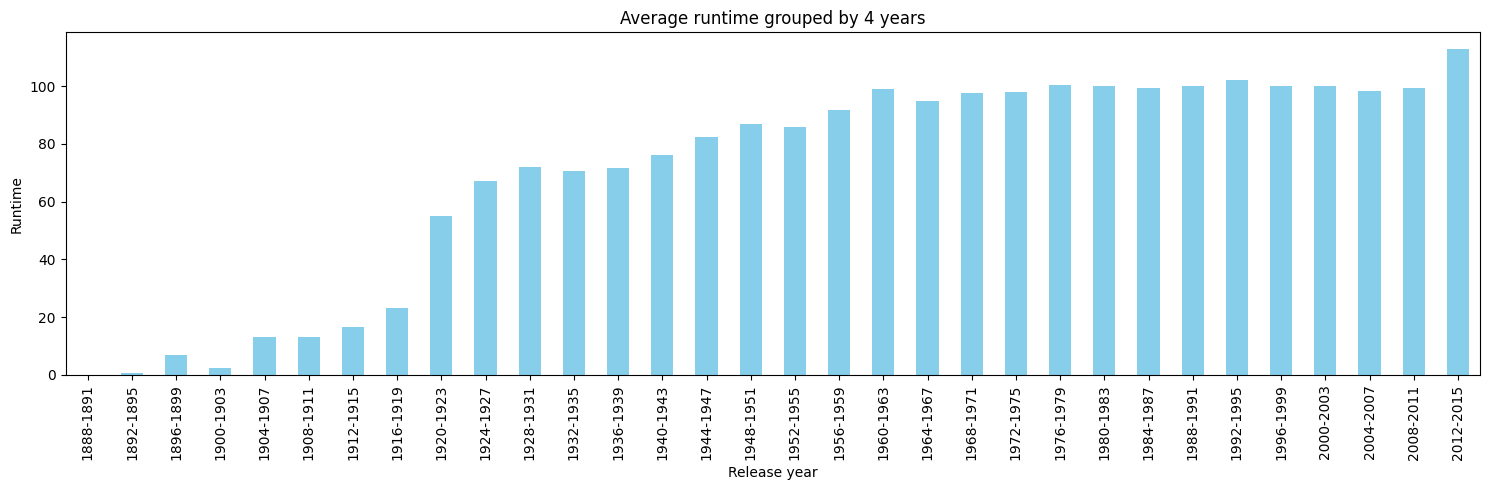

In [ ]:
movies_year_runtime = MOVIES.groupby("release_year")["runtime"].median()

bin_size = 4
binned_runtimes = {}

for i in range(FIRST_MOVIE_YEAR, int(movies_year_runtime.index.max()), bin_size):
    bin_start, bin_end = i, i + bin_size - 1
    
    # Calculate the mean runtime within the current year range (bin)
    total_in_bin = movies_year_runtime[
        (movies_year_runtime.index >= bin_start) & 
        (movies_year_runtime.index <= bin_end)
    ].median()
    
    # Store result in dictionary with bin label as key
    binned_runtimes[f'{bin_start}-{bin_end}'] = total_in_bin

binned_token_counts = pd.Series(binned_runtimes)

# Plot
plt.figure(figsize=(15, 5))
binned_token_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Release year')
plt.ylabel('Runtime')
plt.title(f'Average runtime grouped by {bin_size} years')

plt.tight_layout()
plt.show()

### Genre runtime analysis

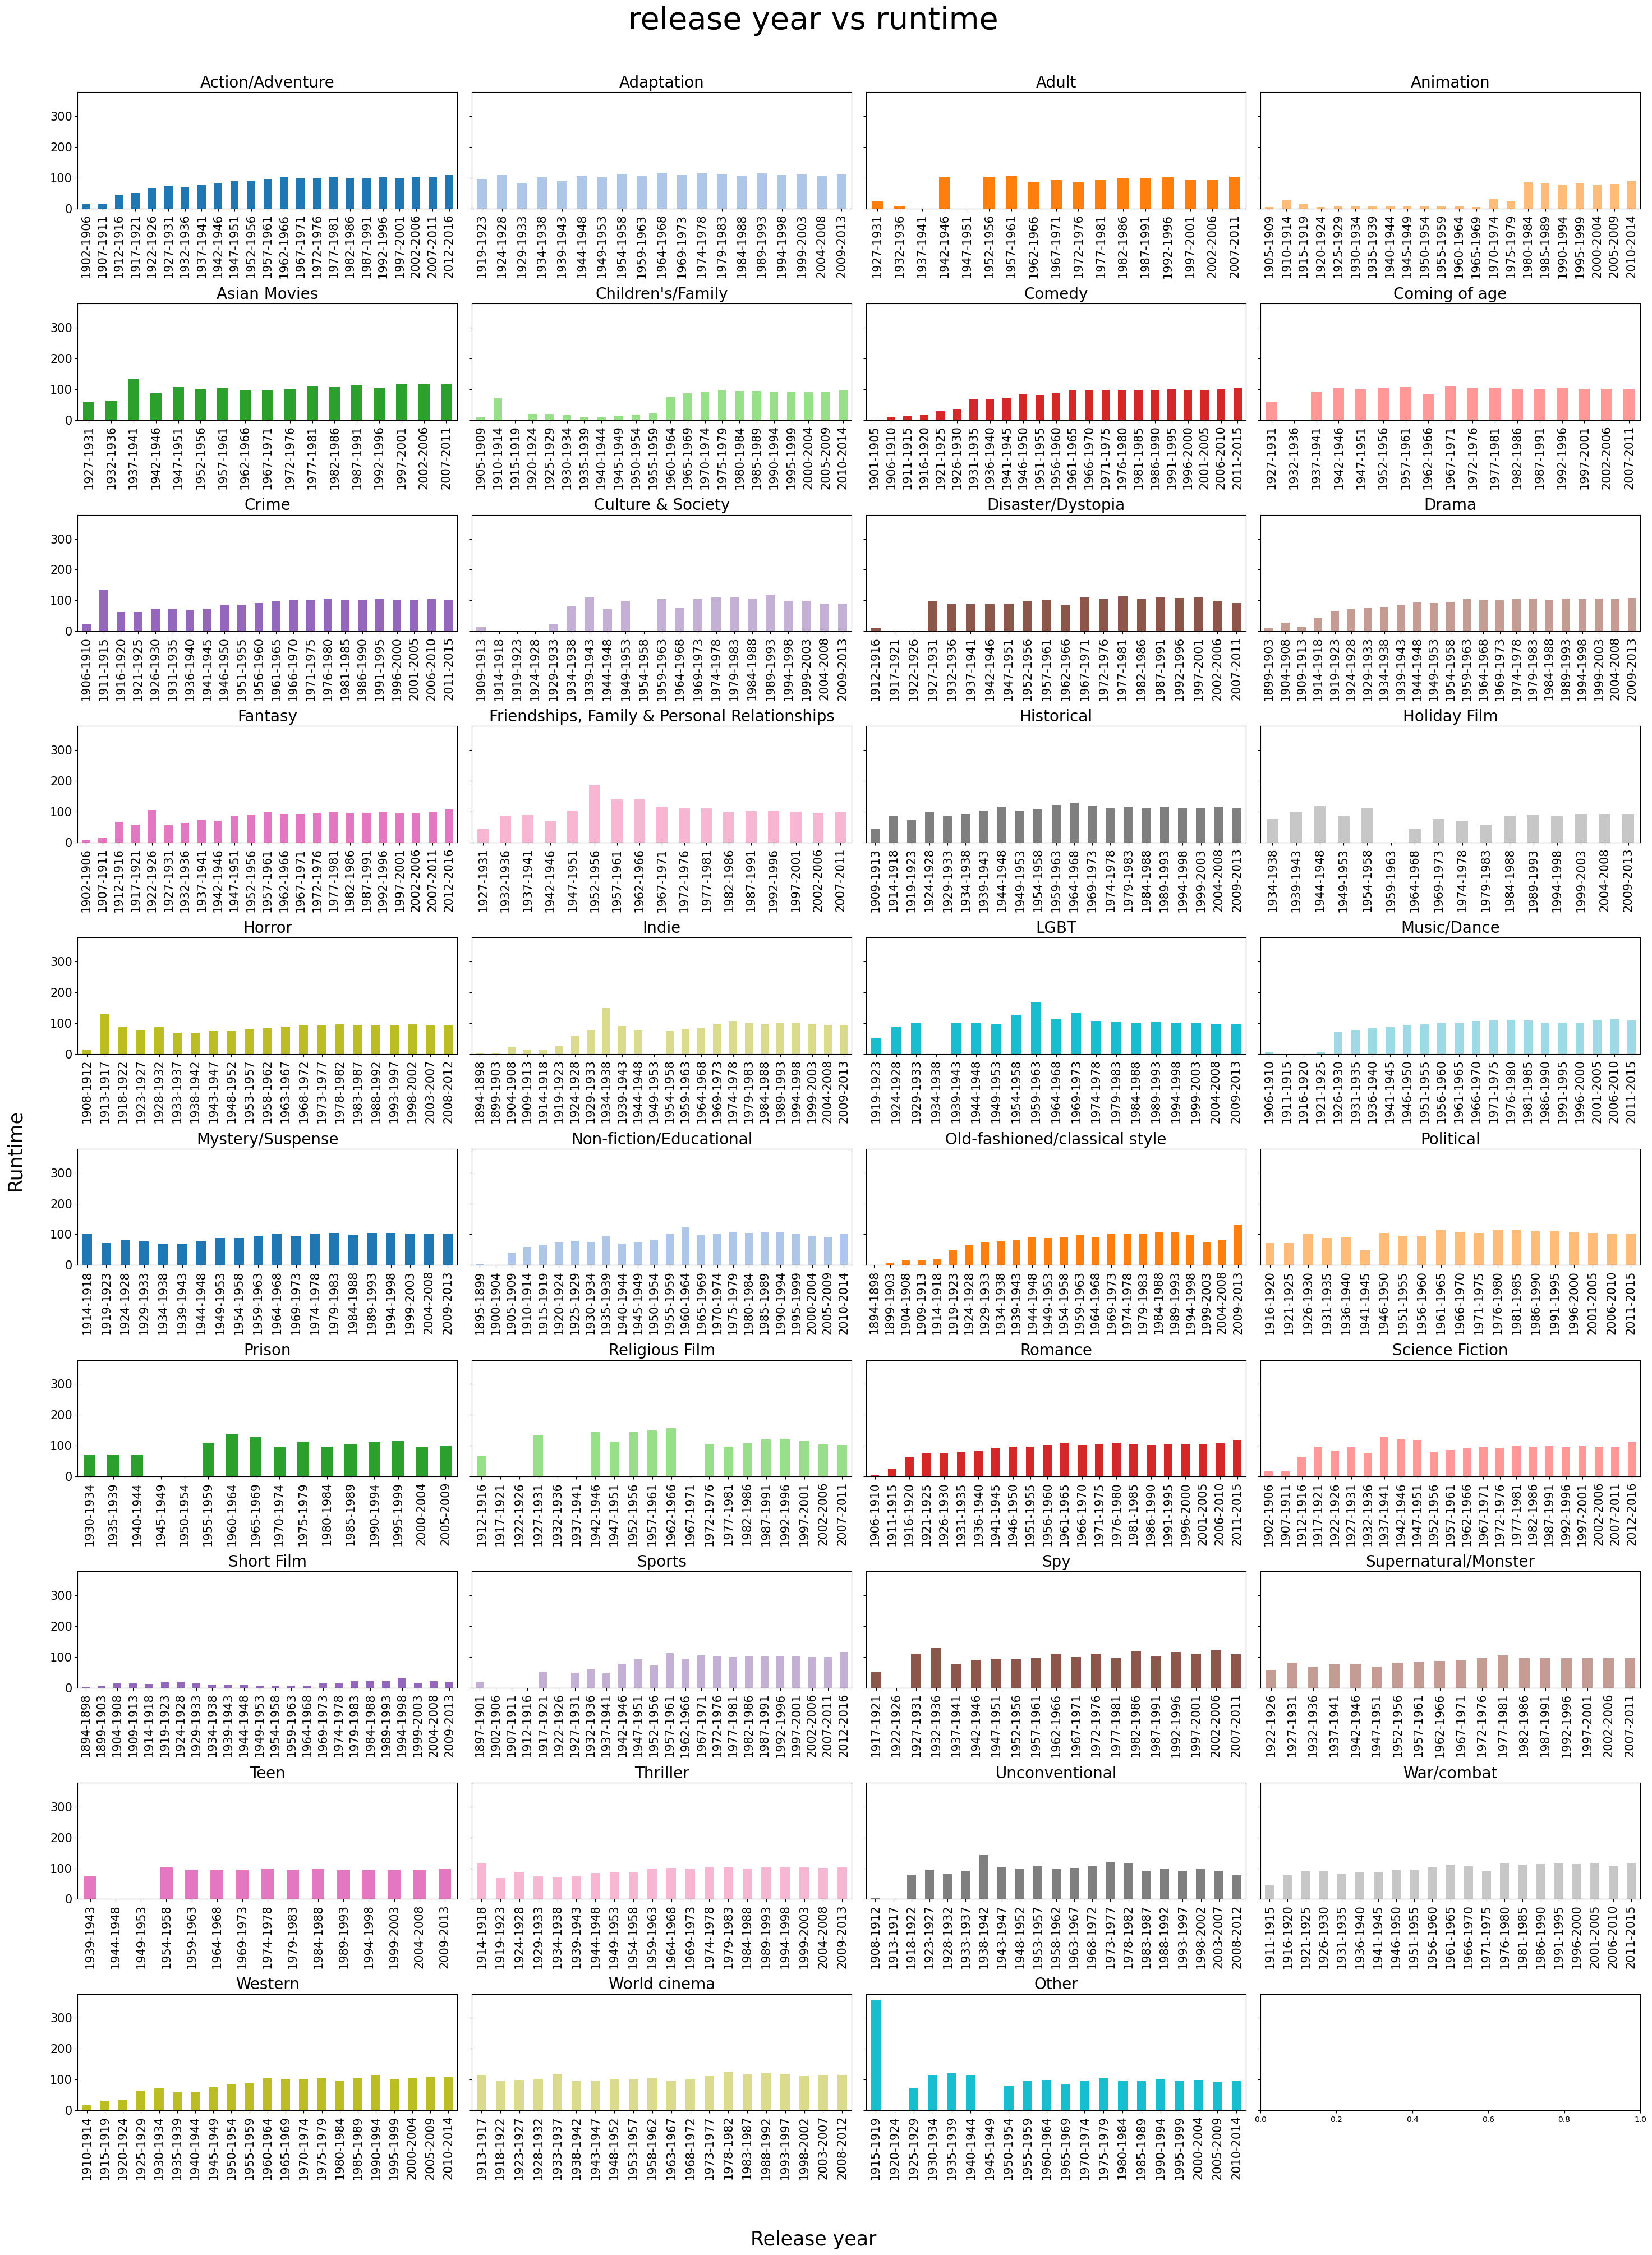

In [ ]:
unique_genre = NEW_GENRE["categories"]


fig, axes = plt.subplots(10, 4, figsize=(30, 40), sharey = True)
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    bin_size = 5
    movies_year_runtime = df_filtered.groupby("release_year")["runtime"].median()
    binned_counts = {}
    for i in range(movies_year_runtime.index.min(), movies_year_runtime.index.max(), bin_size):
        bin_start, bin_end = i, i + bin_size - 1
        
        # Sum all the runtimes counts in this range.
        total_in_bin = movies_year_runtime[(movies_year_runtime.index >= bin_start) & (movies_year_runtime.index <= bin_end)].mean()
        
        binned_counts[f'{bin_start}-{bin_end}'] = total_in_bin


    binned_token_counts = pd.Series(binned_counts)
    color = next(color_iter)
    ax = axes[j//4, j%4]
    binned_token_counts.plot(kind='bar', ax=ax, color=color, fontsize=15)

    ax.set_title(genre, size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.suptitle('release year vs runtime', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

Text(0.5, 1.0, 'Genre vs runtime')

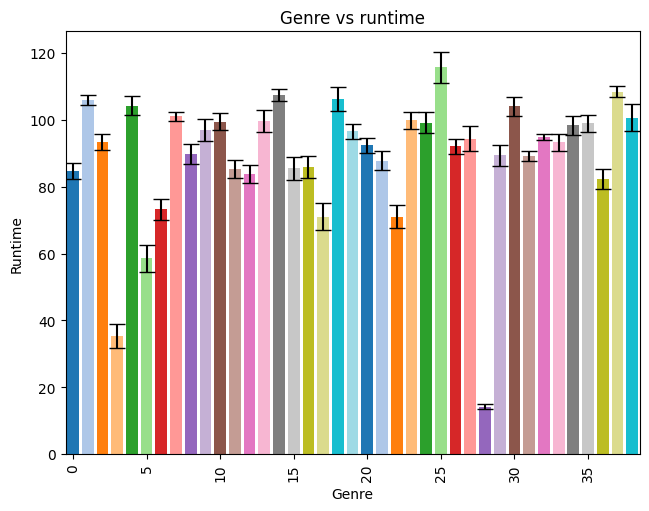

In [ ]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)
average = []
std = []
number_of_year_to_average = 5

for idx, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    medians = df_filtered.groupby("release_year")["runtime"].median()
    average.append(medians.mean())
    std.append(medians.std()/np.sqrt(medians.size))
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(list(unique_genre.keys())[i], average[i], color=color)
    ax.errorbar(list(unique_genre.keys())[i], average[i], yerr=std[i],capsize=6,  color = 'k')
    
ax.set_xlim(-0.5, len(unique_genre) - 0.5) # Set limits to avoid extra space on sides
plt.tight_layout()
ax.set_xlabel("Genre")
ax.set_ylabel("Runtime")
ax.set_title("Genre vs runtime")

### Genre revenue analysis

Text(0.5, 1.0, 'Genre vs revenue')

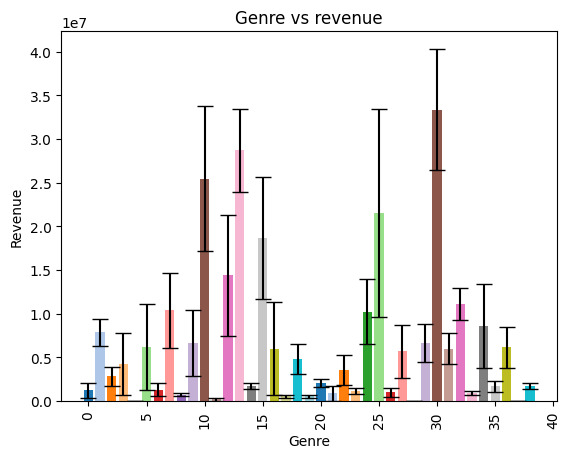

In [ ]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)
average = []
std = []
number_of_year_to_average = 5

for idx, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    group =  df_filtered.groupby("release_year")["revenue"].median()
    average.append(group.mean())
    std.append(group.std()/np.sqrt(group.size))
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(list(unique_genre.keys())[i], average[i], color=color)
    ax.errorbar(list(unique_genre.keys())[i], average[i], yerr=std[i],capsize=6,  color = 'k')
    """ FIX SOMETHING"""

ax.set_xlabel("Genre")
ax.set_ylabel("Revenue")
ax.set_title("Genre vs revenue")

### SCATTER PLOT YEAR VS BUDGET :D

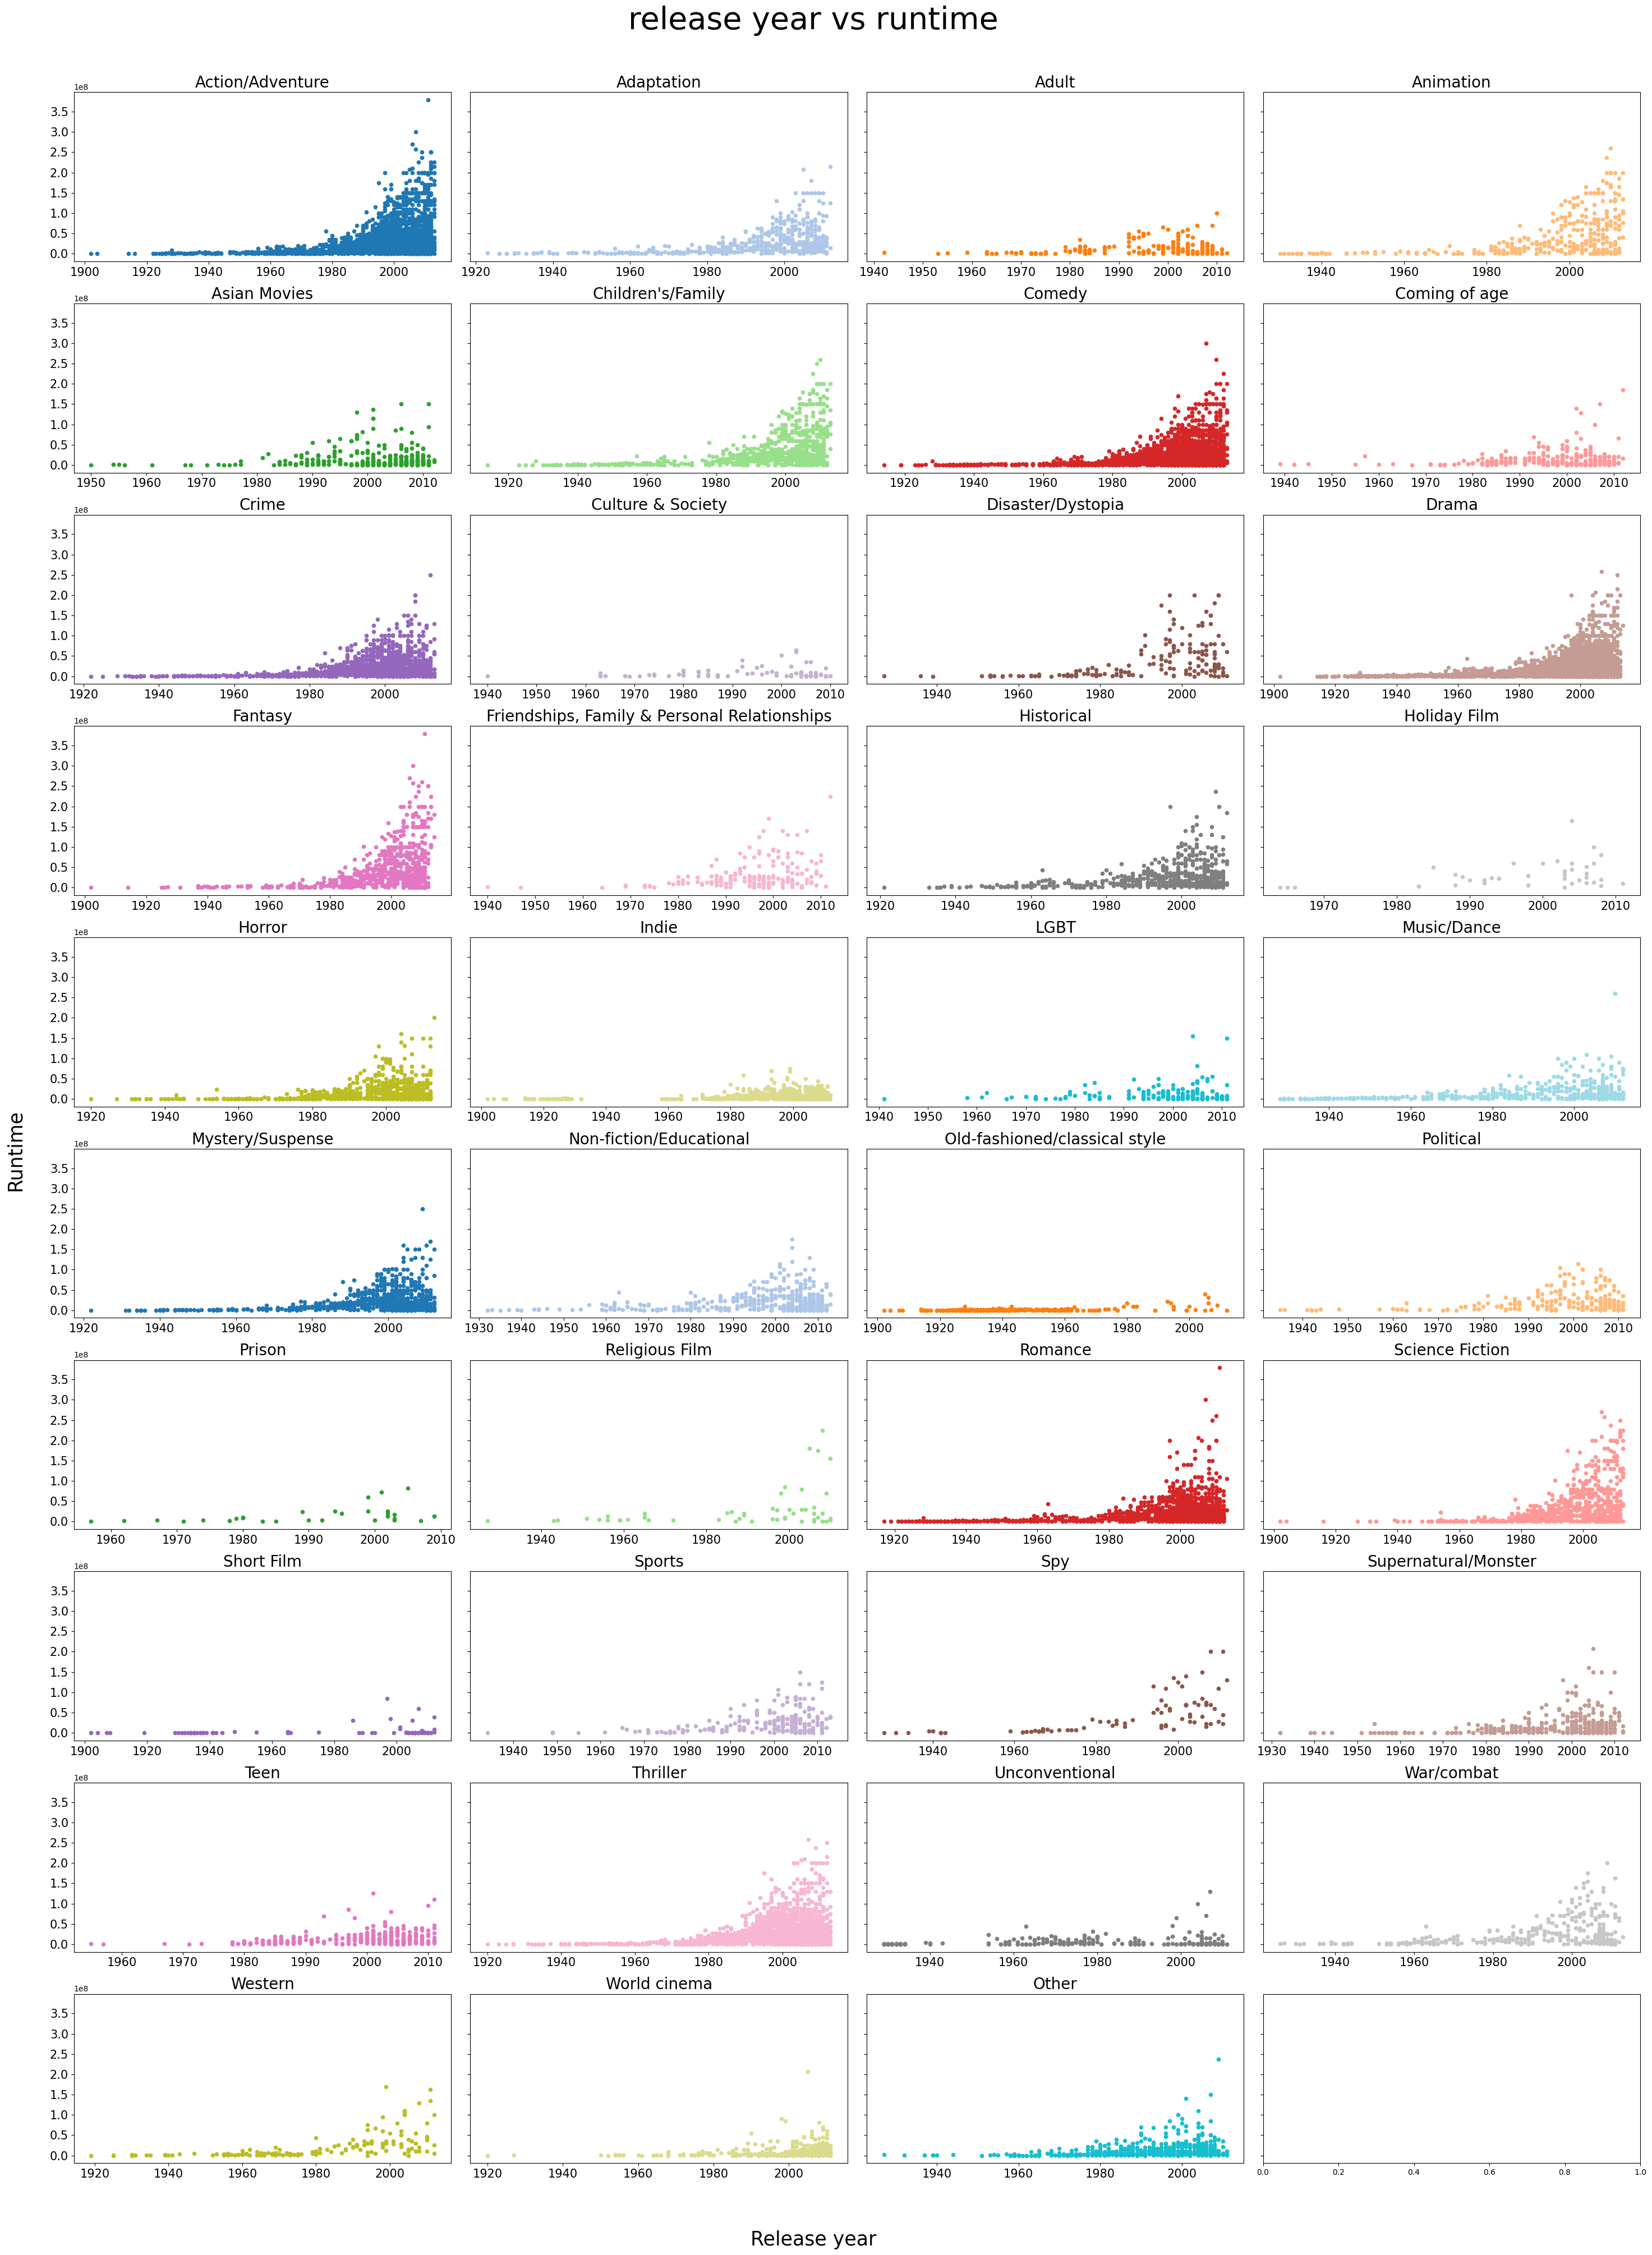

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

unique_genre = NEW_GENRE["categories"]


fig, axes = plt.subplots(10, 4, figsize=(30, 40), sharey = True)
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered.dropna(subset=["budget"], inplace=True)
    df_filtered['budget'] = df_filtered['budget'].astype(int)
    df_filtered = df_filtered[df_filtered['budget'] != 0]
    color = next(color_iter)
    ax = axes[j//4, j%4]
    df_filtered.plot.scatter(x='release_year', y='budget', ax=ax, color=color, fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_title(genre, size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.suptitle('release year vs runtime', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

### HEATMAP (╯°□°)╯︵ ┻━┻

39


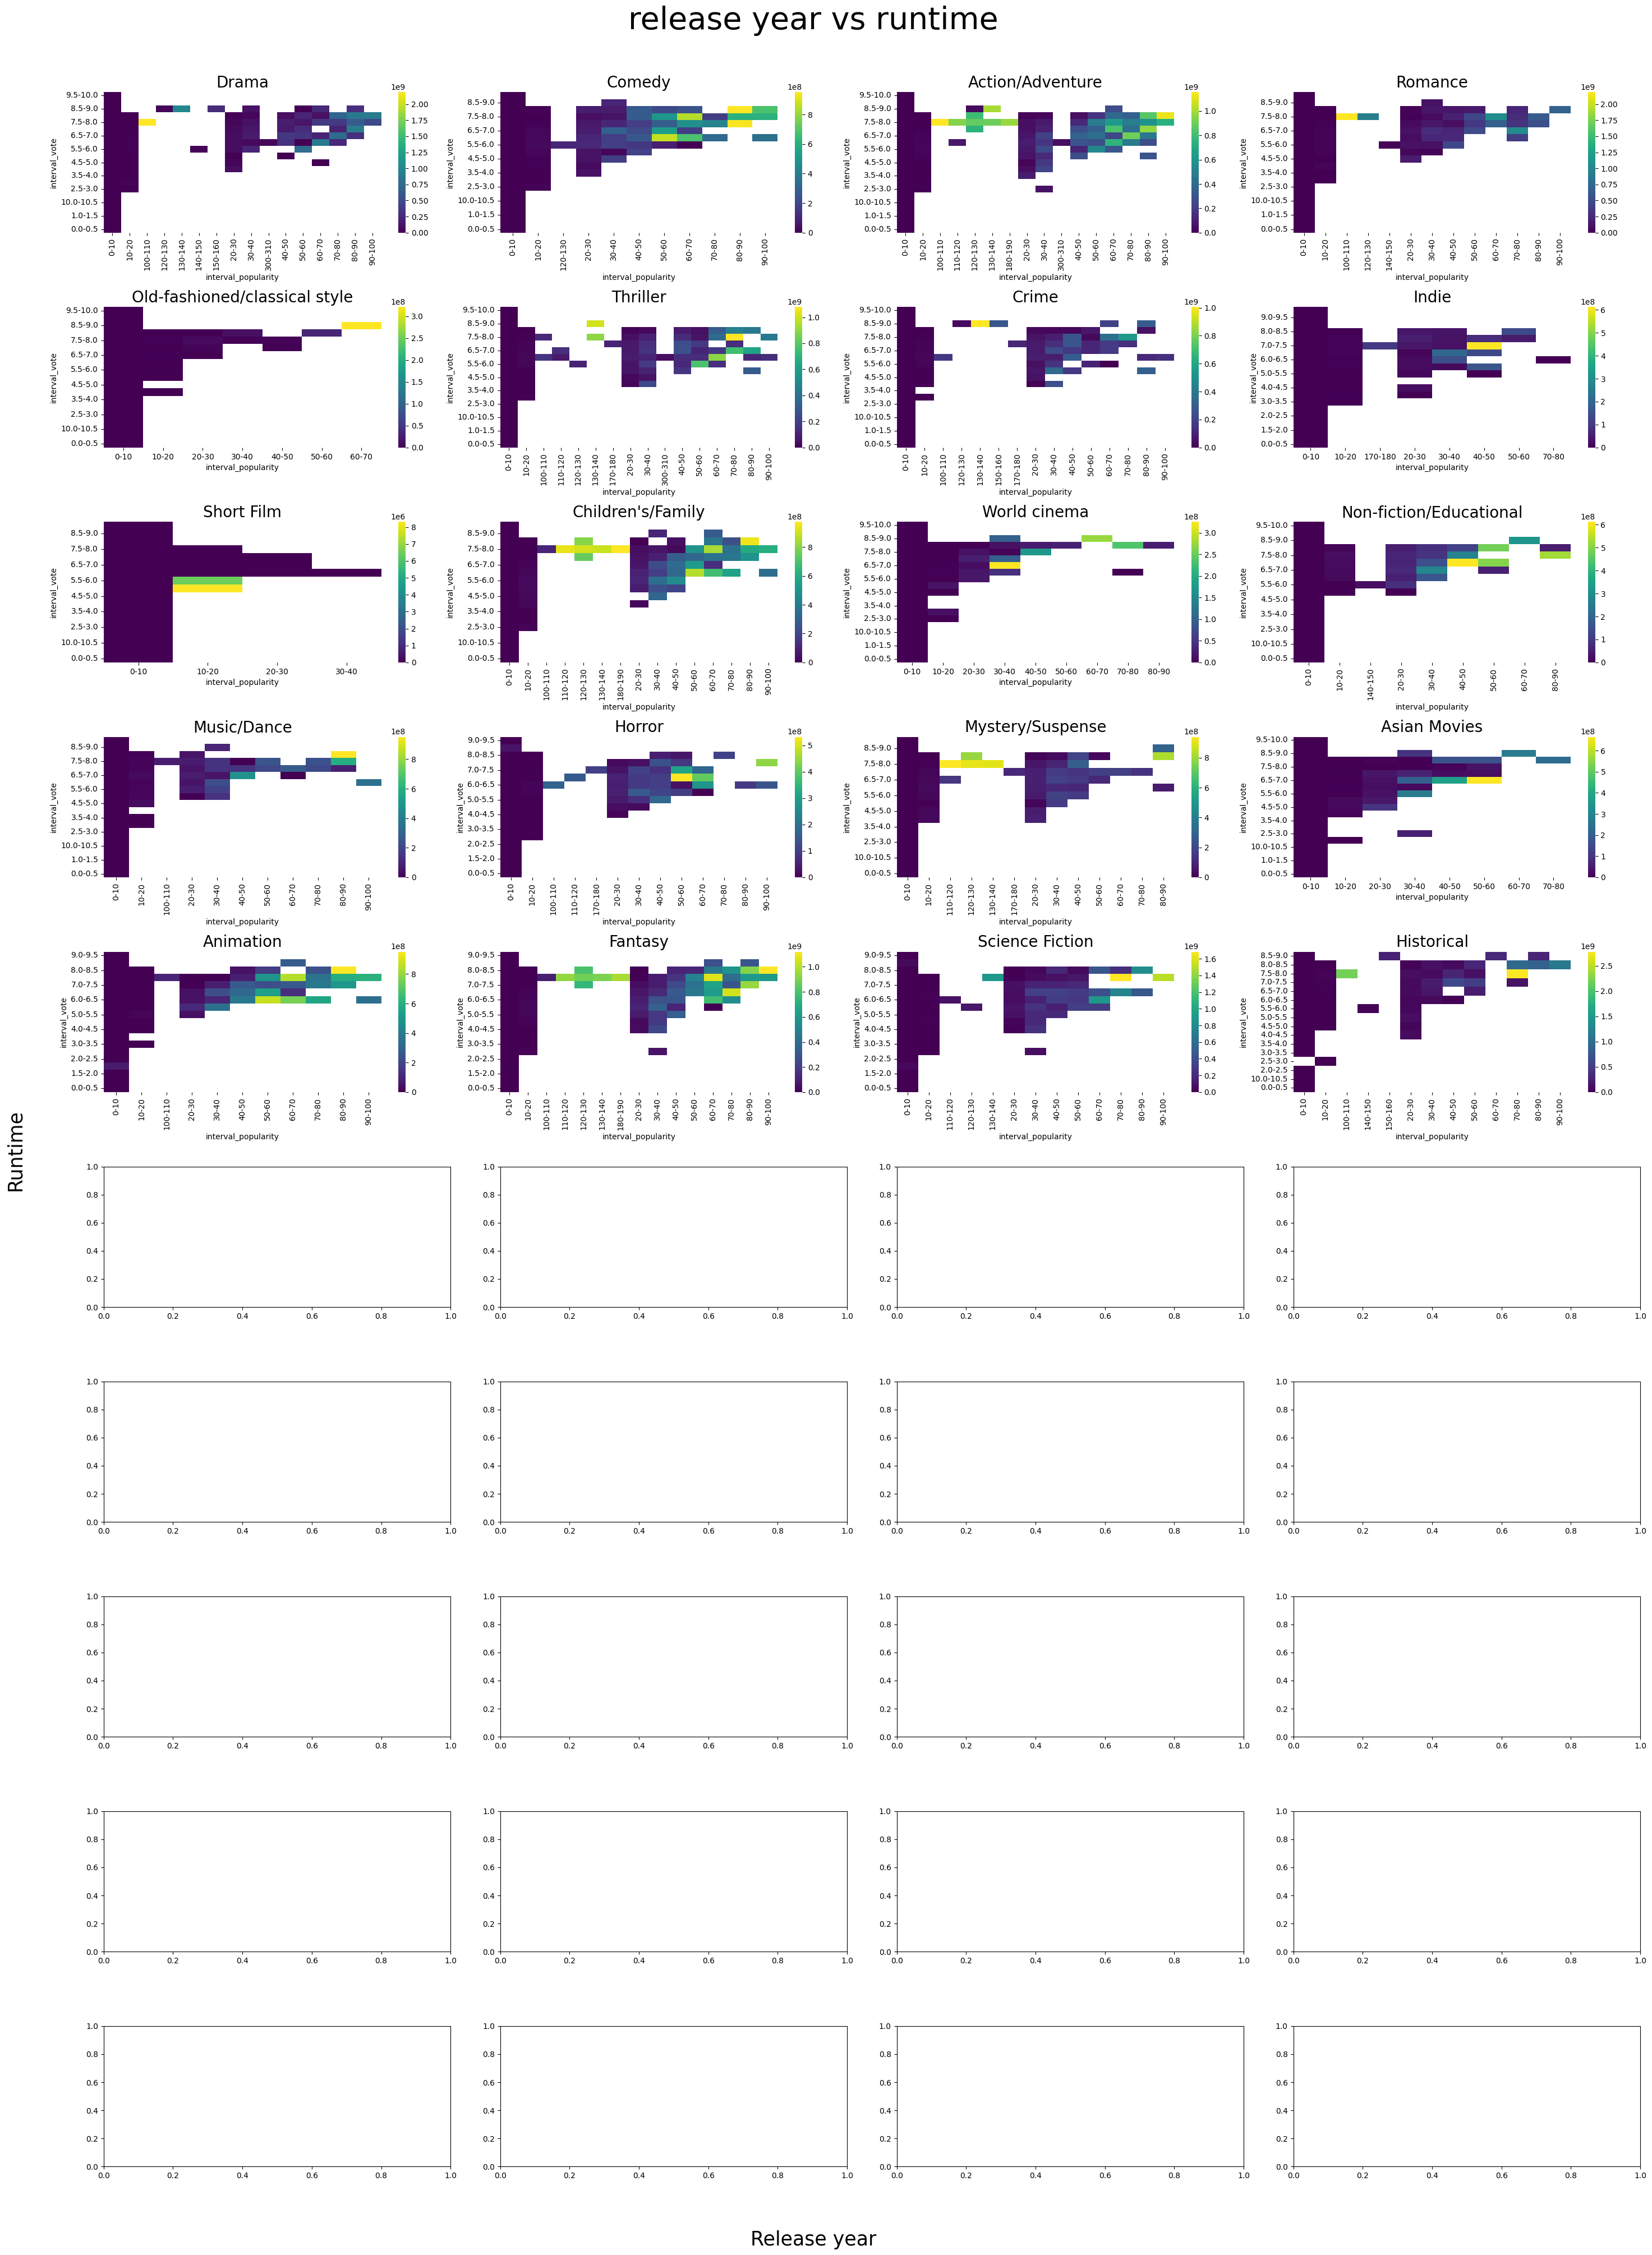

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

unique_genre = list()
MOVIES["new_genres"].apply(lambda x: unique_genre.extend(x))
unique_genre = Counter(unique_genre)
print(len(unique_genre))
unique_genre = {k: v for k, v in sorted(unique_genre.items(), key=lambda item: item[1], reverse=True)}
unique_genre = {k: unique_genre[k] for k in list(unique_genre)[:20]}
#unique_genre = {x:unique_genre[x] for x in unique_genre if unique_genre[x] >= 300}


fig, axes = plt.subplots(10, 4, figsize=(30, 40))
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):
    

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered.dropna(subset=["vote_average", "popularity"], inplace=True)
    df_filtered['interval_vote'] = df_filtered['vote_average'].astype(float).apply(lambda x: f'{int(x/0.5)*0.5}-{int(x/0.5+1)*0.5}')
    df_filtered['interval_popularity'] = df_filtered['popularity'].astype(float).apply(lambda x: f'{int(x/10)*10}-{int(x/10+1)*10}')
    df_temp = pd.crosstab(df_filtered['interval_vote'], df_filtered['interval_popularity'], values = df_filtered['revenue'],
                  margins=False, aggfunc='median')

    color = next(color_iter)
    ax = axes[j//4, j%4]
    sns.heatmap(df_temp, annot=False, ax=ax, cmap='viridis')
    ax.invert_yaxis()
    ax.set_title(genre, size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.suptitle('release year vs runtime', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

# Character managment

In [ ]:
vgh

NameError: name 'vgh' is not defined

# MOVIE GENRE PREDICTOR MODEL

In [ ]:
import random
import torch

### Data spliting and cross validation definition

In [ ]:
def cross_validation_balanced_split(data, training_columns, testing_column, set_to_test, train_proportion = 0.2, seed = 42):
    divisions = int(1 / train_proportion)
    if set_to_test is None or set_to_test > divisions or set_to_test < 0:
        print("BE CAREFUL, ONLY VALUES FORM 0 to 1. Setting testing set to 0")
        set_to_test = 0
    # GET THE MOST FROM THE UNBALANCED CLASS
    train_proportion = train_proportion # 1/train_proportion divisioins, as default 2
    n = np.round(train_proportion, 0).astype(int)
        
    data_suffled = data.sample(frac=1, random_state=seed).reset_index(drop=True)

    training_set =  data_suffled[:n*set_to_test] + data_suffled[n*(set_to_test+1):] 
    testing_set = data_suffled[n*set_to_test:n*(set_to_test+1)]

    return (
        training_set[training_columns], 
        training_set[testing_column], 
        testing_set[training_columns], 
        testing_set[testing_column], 
    )

In [ ]:
training_columns = []
testing_column = []

training_set, training_target_set, testing_set, testing_target_set = cross_validation_balanced_split(MOVIES, 
                                                                                                     training_columns,
                                                                                                     testing_column,
                                                                                                     set_to_test = SETTINGS["MODEL_SETTINGS"]["TEST_SET"], 
                                                                                                     train_proportion =  SETTINGS["MODEL_SETTINGS"]["TEST_PROPORTION"],
                                                                                                     seed = SETTINGS["MODEL_SETTINGS"]["SEED"],
                                                                                                     )

### Model definition

In [ ]:
get_model = lambda feature_size, genre_size, layer_size: torch.nn.Sequential(
    # Input layer
    torch.nn.Linear(feature_size, layer_size),
    torch.nn.ReLU(),
    
    # Hidden layers
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    
    # Output layer
    torch.nn.Linear(layer_size, genre_size),
    torch.nn.Sigmoid() # To get probabilities
)

### Model instance

In [ ]:
feature_size = 30 #len(training_columns)
genre_size = 30 #len(movie_genre)

model_factory = lambda: get_model(feature_size, genre_size, SETTINGS["MODEL_SETTINGS"]["LAYER_SIZE"])
model = model_factory()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device=device)

optimizer_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-3,
)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

### Model training

In [ ]:
def train_model(batches_train, batches_test, model, optimizer, classification_threshold, device):
    # Set model to training mode 
    model.train()

    loss_history = []
    accuracy_history = []
    f_score_history = []
    precision_history = []
    recall_history = []
    # Change the loop to get batch_idx, data and target from train_loader
    for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
        N = data.shape[0] 
        Dy = target.shape[1] # Number of possible genre 
        
        # Move the data to the device
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = torch.nn.BCELoss()(output, target)
        loss_float = loss.item()
        # Backpropagate loss & Perform an optimizer step
        loss.backward()
        optimizer.step()
        
        
        # Compute accuracy and loss of the batch
        output_hot, correct = get_output_hot(output, target, classification_threshold)
        accuracy = correct.item() / (N * Dy) 
        f_score, precision, recall = compute_avg_f_score(output_hot, target)
        
        accuracy_history.append(accuracy)
        loss_history.append(loss_float)
        f_score_history.append(f_score)
        precision_history.append(precision)
        recall_history.append(recall)
        
        if sample_i % (1000 // N) == 0: # Every 1000 samples
            print(f'Batch {loss_float = :.3f}')
            print(f'Batch {accuracy = :.3f}')
            print(f'Batch {f_score = :.3f}')
            print(f'Batch {precision = :.3f}')
            print(f'Batch {recall = :.3f}')
    # print(f"{loss_history = }, {accuracy_history = }")
    return model, loss_history, accuracy_history

def get_output_hot(output, target, classification_threshold):
    output_hot = (output > classification_threshold).int() # we have |N| x |genre| matrix
    correct = torch.sum(output_hot == target)

    return output_hot, correct

def compute_avg_f_score(output_hot, target):
    true_positives = torch.sum((output_hot & target), dim = 1)
    false_positives = torch.sum((output_hot & ~target), dim = 1)
    false_negatives = torch.sum((~output_hot & target), dim = 1)
    
    denominator = true_positives + false_positives
    precision = torch.where(denominator > 0,
                            true_positives / denominator,
                            torch.zeros_like(true_positives)
                            )
    
    denominator = true_positives + false_negatives
    recall = torch.where(denominator > 0,
                         true_positives / denominator,
                         torch.zeros_like(true_positives)
                         )
    
    denominator = precision + recall
    f_score = torch.where(denominator > 0,
                          2*(precision * recall) / denominator,
                          torch.zeros_like(true_positives)
                          )
                          
    return torch.mean(f_score), torch.mean(precision), torch.mean(recall)

We use stochastic training for better performance. The batch size is 10 by default.

In [ ]:
def get_training_batch(training_set, target_set, batch_size = 10):
    assert len(training_set) == len(target_set), "Lists must be of equal length."
    
    batches_train = []
    batches_test = []
    for i in range(0, len(training_set), batch_size):
        # batches_train.append(training_set[i:i+batch_size])
        # batches_test.append(target_set[i:i+batch_size])
        batches_train.append(torch.tensor(training_set[i:i+batch_size]))
        batches_test.append(torch.tensor(target_set[i:i+batch_size]))
        
    return batches_train, batches_test

In [ ]:
batches_train, batches_test = get_training_batch(training_set, training_target_set)

trained_model, train_loss, train_acc = train_model(
    batches_train, batches_test, model, optimizer, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"], device
) 

### Training Plotting

In [ ]:
batch_indices = [i for i in range(len(batches_train))]

plt.figure(figsize=(6.4, 4.8))
plt.subplot(1, 2, 1)
plt.plot(batch_indices, trained_model)
plt.xlabel("Batch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(batch_indices, train_loss)
plt.xlabel("Batch")
plt.ylabel("Loss")

### Model testing

In [ ]:
def test_model(model, testing_set, testing_target_set, classification_threshold):
    N = testing_set.shape[0] 
    Dy = testing_target_set.shape[1] 
    
    with torch.no_grad():
        output = model(testing_set)
        
    output_hot, correct = get_output_hot(output, testing_target_set, classification_threshold)
    
    accuracy = correct.item() / (N * Dy) 
    
    print(f'Testing accuracy = {accuracy:0.3f}')
    
    return output_hot
    

In [ ]:
testing_set = torch.tensor(testing_set).to(device)
testing_target_set = torch.tensor(testing_target_set).to(device)

predictions = test_model(trained_model, testing_set, testing_target_set, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"])

genre_labels = ["Action", "Drama", "Comedy", "Sci-Fi", "Horror", "Romance", "Documentary", "Fantasy", "Thriller", "Animation"]
predicted_genre = []

for movie_prediction in predictions:
    genres = [genre_labels[i] for i, is_genre in enumerate(movie_prediction) if is_genre == 1]
    predicted_genre.append(genres)

predictins_output = pd.DataFrame({
    'wikipedia_movie_ID': testing_set["wikipedia_movie_ID"],
    'name': testing_set["name"],
    'predicted_genres': predicted_genre,
})


predictins_output.to_csv("movies_predicted_genre.csv", index = False)


# TRASH CODE TESTING

In [ ]:
training_set = [i for i in range(1, 105)]
training_target_set = [i**2 for i in range(1, 105)]


batches_train, batches_test = get_training_batch(training_set, training_target_set)

print(batches_train, batches_test)

for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
     print(f"\n\n{sample_i = }")
     print(f"{data = }")
     print(f"{target = }")

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50], [51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [61, 62, 63, 64, 65, 66, 67, 68, 69, 70], [71, 72, 73, 74, 75, 76, 77, 78, 79, 80], [81, 82, 83, 84, 85, 86, 87, 88, 89, 90], [91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [101, 102, 103, 104]] [[1, 4, 9, 16, 25, 36, 49, 64, 81, 100], [121, 144, 169, 196, 225, 256, 289, 324, 361, 400], [441, 484, 529, 576, 625, 676, 729, 784, 841, 900], [961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600], [1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500], [2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600], [3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900], [5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400], [6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100], [8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 

In [ ]:
hot =  torch.tensor([[0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,1,1], [0,0,0,0,0,1,0,0,0,1], [0,0,0,0,0,0,1,0,0,1], [0,0,0,0,0,1,0,0,0,1]])
targ = torch.tensor([[0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,1,1,0,0,1], [0,0,0,0,0,1,0,0,0,1], [0,0,0,0,0,1,0,1,1,1]])

f_score, precision, recall = compute_avg_f_score(hot, targ)
print(f'{f_score = :.3f}, {precision = :.3f}, {recall = :.3f},')

f_score = 0.727, precision = 0.800, recall = 0.733,
